In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
BASE_PATH = "./data/chest_xray/"
TRAIN_DIR = BASE_PATH + "train/"

TEST_DIR =  BASE_PATH + "test/"
LABELS = ['NORMAL', 'PNEUMONIA']

for data_dir in [TRAIN_DIR, TEST_DIR]:
    for label in LABELS:
        count = len(os.listdir(data_dir + label))
        print('{0} {1} # {2}'.format(label, data_dir, count))

NORMAL ./data/chest_xray/train/ # 1350
PNEUMONIA ./data/chest_xray/train/ # 3884
NORMAL ./data/chest_xray/test/ # 234
PNEUMONIA ./data/chest_xray/test/ # 390


In [3]:
total_train = len(os.listdir(TRAIN_DIR + 'NORMAL')) + len(os.listdir(TRAIN_DIR + 'PNEUMONIA'))
total_test = len(os.listdir(TEST_DIR + 'NORMAL')) + len(os.listdir(TEST_DIR + 'PNEUMONIA'))
(total_train, total_test)

(5234, 624)

NORMAL


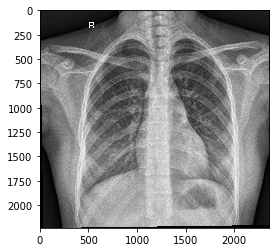

PNEUMONIA


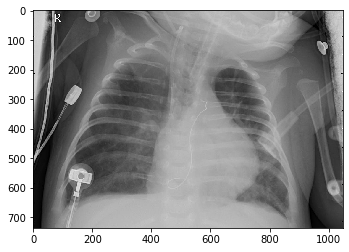

In [4]:
for label in LABELS:
    path = TRAIN_DIR + label
    img = os.listdir(path)[0]
    img_normal = load_img(path + '/' + img)
    print(label)
    plt.imshow(img_normal)
    plt.show()

In [108]:
img_width, img_height = 300, 300
batch_size = 32

In [109]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15                                   
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5232 images belonging to 2 classes.


In [110]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [111]:
def plt_history(history):
    plt.plot(history.history['val_acc'])    
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['test', 'train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['val_loss'])    
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['test', 'train'], loc='upper left')
    plt.show()

In [112]:
from keras import backend as K
K.image_data_format()

'channels_last'

In [254]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [256]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=3, input_shape=(img_width, img_height, 1)))
    model.add(Conv2D(32, (3,3), strides=3))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(64, (2,2), strides=2))
    model.add(Conv2D(32, (2,2), strides=2))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
      optimizer='adam',                  
      metrics=['acc', f1_m, precision_m, recall_m])
    model.summary()
    
    return model    


In [257]:
epochs = 50
def run_model(model):
    checkpoint = ModelCheckpoint('checkpoints/checkpoint-3', monitor='val_acc', verbose=1, save_best_only=True, mode='max')    

    model.fit_generator(
        train_generator,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=total_test // batch_size,
        callbacks=[checkpoint]
    )
    return model

In [258]:
model = build_model()
# 0.91216

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_187 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 33, 33, 32)        9248      
_________________________________________________________________
activation_89 (Activation)   (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 5, 5, 64)          8256      
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 2, 2, 32)          8224      
_________________________________________________________________
activation_90 (Activation)   (None, 2, 2, 32)          0         
__________

Epoch 1/50
163/163 [==============================] - 134s 819ms/step - loss: 0.5846 - acc: 0.7408 - f1_m: 0.8479 - precision_m: 0.7442 - recall_m: 0.9941 - val_loss: 0.6921 - val_acc: 0.6250 - val_f1_m: 0.7692 - val_precision_m: 0.6250 - val_recall_m: 1.0000

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to checkpoints/checkpoint-3
Epoch 2/50
163/163 [==============================] - 123s 756ms/step - loss: 0.4719 - acc: 0.7767 - f1_m: 0.8589 - precision_m: 0.8046 - recall_m: 0.9341 - val_loss: 0.4820 - val_acc: 0.7516 - val_f1_m: 0.8055 - val_precision_m: 0.7887 - val_recall_m: 0.8231

Epoch 00002: val_acc improved from 0.62500 to 0.75160, saving model to checkpoints/checkpoint-3
Epoch 3/50
163/163 [==============================] - 125s 769ms/step - loss: 0.3302 - acc: 0.8625 - f1_m: 0.9058 - precision_m: 0.9075 - recall_m: 0.9111 - val_loss: 0.6347 - val_acc: 0.7340 - val_f1_m: 0.8211 - val_precision_m: 0.7082 - val_recall_m: 0.9769

Epoch 00003: val_acc did not

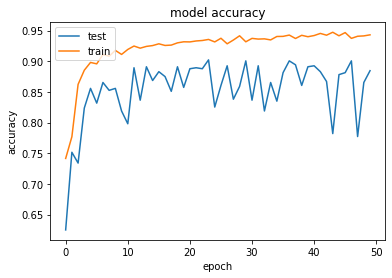

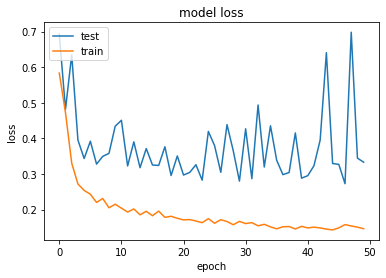

In [259]:
model = run_model(model)
plt_history(model.history)

In [275]:
manual_datagen = ImageDataGenerator(rescale=1. / 255)
manual_generator = manual_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=624,
    target_size=(img_width, img_height),
    class_mode='binary',
    color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [280]:
predictions = model.predict_generator(manual_generator, steps=1)

In [281]:
labels = {'TN': 0, 'FN': 0, 'TP': 0, 'FP': 0}
for filepath, prediction in zip(manual_generator.filepaths, predictions):
    if ('NORMAL' in filepath) and (prediction < 0.5):
        labels['TN'] = labels['TN'] + 1
    elif ('NORMAL' in filepath) and (prediction > 0.5):
        labels['FN'] = labels['FN'] + 1
    elif ('PNEUMONIA' in filepath) and (prediction > 0.5):
        labels['TP'] = labels['TP'] + 1
    elif ('PNEUMONIA' in filepath) and (prediction < 0.5):
        labels['FP'] = labels['FP'] + 1

labels

{'TN': 69, 'FN': 165, 'TP': 275, 'FP': 115}